## Group 6: Wahayb Alotaibi, Jessica Hankele Torres, Madhawi Alharbi, Jana Alsabyani

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib
import sklearn
import seaborn as sns
import scipy

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [3]:
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import matthews_corrcoef
from sklearn.preprocessing import label_binarize

# Defining the Question

The dataset used in this investigation includes three total wells that have depth, gamma ray, resistivity,density, and porosity measurements. The objective is to develop classifiers for lithology/facies (type of rock) using several machine learning techniques. The different techniques will be compared to each other to find one optimal solution for classifying the lithology at different depths for wells as they are being drilled in a geologically similar area. To accomplish this, the two wells in the dataset that have corresponding facies for that depth will be used as the training set, while the third well without facies information will be used as the test set. Before we begin classifying the facies, we will look into any relationships between the properties measured and the listed facies classification.

# Data Collection

The Volve Dataset contains logs from Wells 13, 14, and 15 which are in the Volve oilfield located in the North Sea. The three wells have measurements of gamma ray (GR) in API units, true resistivity (RT) in ohm-meters, bulk density (RHOB) in grams per cubic centimeters, and neutron porosity (NPHI) in percent measurements.These measurements are taken using a well log during drilling resulting in measurement with depth at an interval of half a foot.

Wells 14 and 15 include the target output which is the listed lithology. The lithlogies included in this dataset include include SS, CB, SH, and UN which represent sandstone, carbonate, shale, and unclassified respectively. This facies data will be our target, and what is being predicted for Well 13 which does not have corresponding facies data. The dataset has already had identifying information of the wells removed and is able to be used for learning purposes. New features can be generated by using known correlations between the measurements provided and determining other petrophysical properties from that.

Dataset source: https://discovervolve.com/2020/04/02/__how_to_access_volve/

In [4]:
w14=pd.read_excel('VolveData_Project.xlsx', sheet_name='well 14',index_col='Depth')
w15=pd.read_excel('VolveData_Project.xlsx', sheet_name='well 15',index_col='Depth')
df=pd.concat([w14,w15])

Only importing wells 14 and 15 as they have target data and will therefore make up the training set.

In [5]:
df.head()

,Well,GR,RT,RHOB,NPHI,Facies
Depth,,,,,,
3178.5,14,50.2190,0.5888,2.3296,0.3657,SH
3179.0,14,47.2468,0.7768,2.3170,0.3776,UN
3179.5,14,49.5247,1.0707,2.2960,0.5390,SH
3180.0,14,44.9124,1.4460,2.2514,0.5482,UN
3180.5,14,47.0048,0.9542,2.2733,0.5076,UN


# Data Cleaning and Preparation

In [6]:
# drop the column number as it is not helpful in predicting lithology
df = df.drop(columns=['Well'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 3241 entries, 3178.5 to 4085.5
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   GR      3241 non-null   float64
 1   RT      3241 non-null   float64
 2   RHOB    3241 non-null   float64
 3   NPHI    3241 non-null   float64
 4   Facies  3241 non-null   object 
dtypes: float64(4), object(1)
memory usage: 151.9+ KB


In [7]:
df.describe()

,GR,RT,RHOB,NPHI
count,3241.000000,3241.000000,3241.000000,3241.000000
mean,51.379917,4.292569,2.432688,0.207456
std,57.700965,14.524740,0.147662,0.104241
min,3.655000,0.094000,1.805100,0.013500
25%,17.433000,1.014000,2.311000,0.133600
50%,34.083600,1.864900,2.459000,0.187900
75%,71.846000,3.697700,2.550000,0.267500
max,1567.590000,461.170000,3.149300,0.853200


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 3241 entries, 3178.5 to 4085.5
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   GR      3241 non-null   float64
 1   RT      3241 non-null   float64
 2   RHOB    3241 non-null   float64
 3   NPHI    3241 non-null   float64
 4   Facies  3241 non-null   object 
dtypes: float64(4), object(1)
memory usage: 151.9+ KB


In [9]:
print(df.isnull().sum())

GR        0
RT        0
RHOB      0
NPHI      0
Facies    0
dtype: int64


There are no null values to deal with in this dataset.<br>We will no wlook at the distribution of each feature.

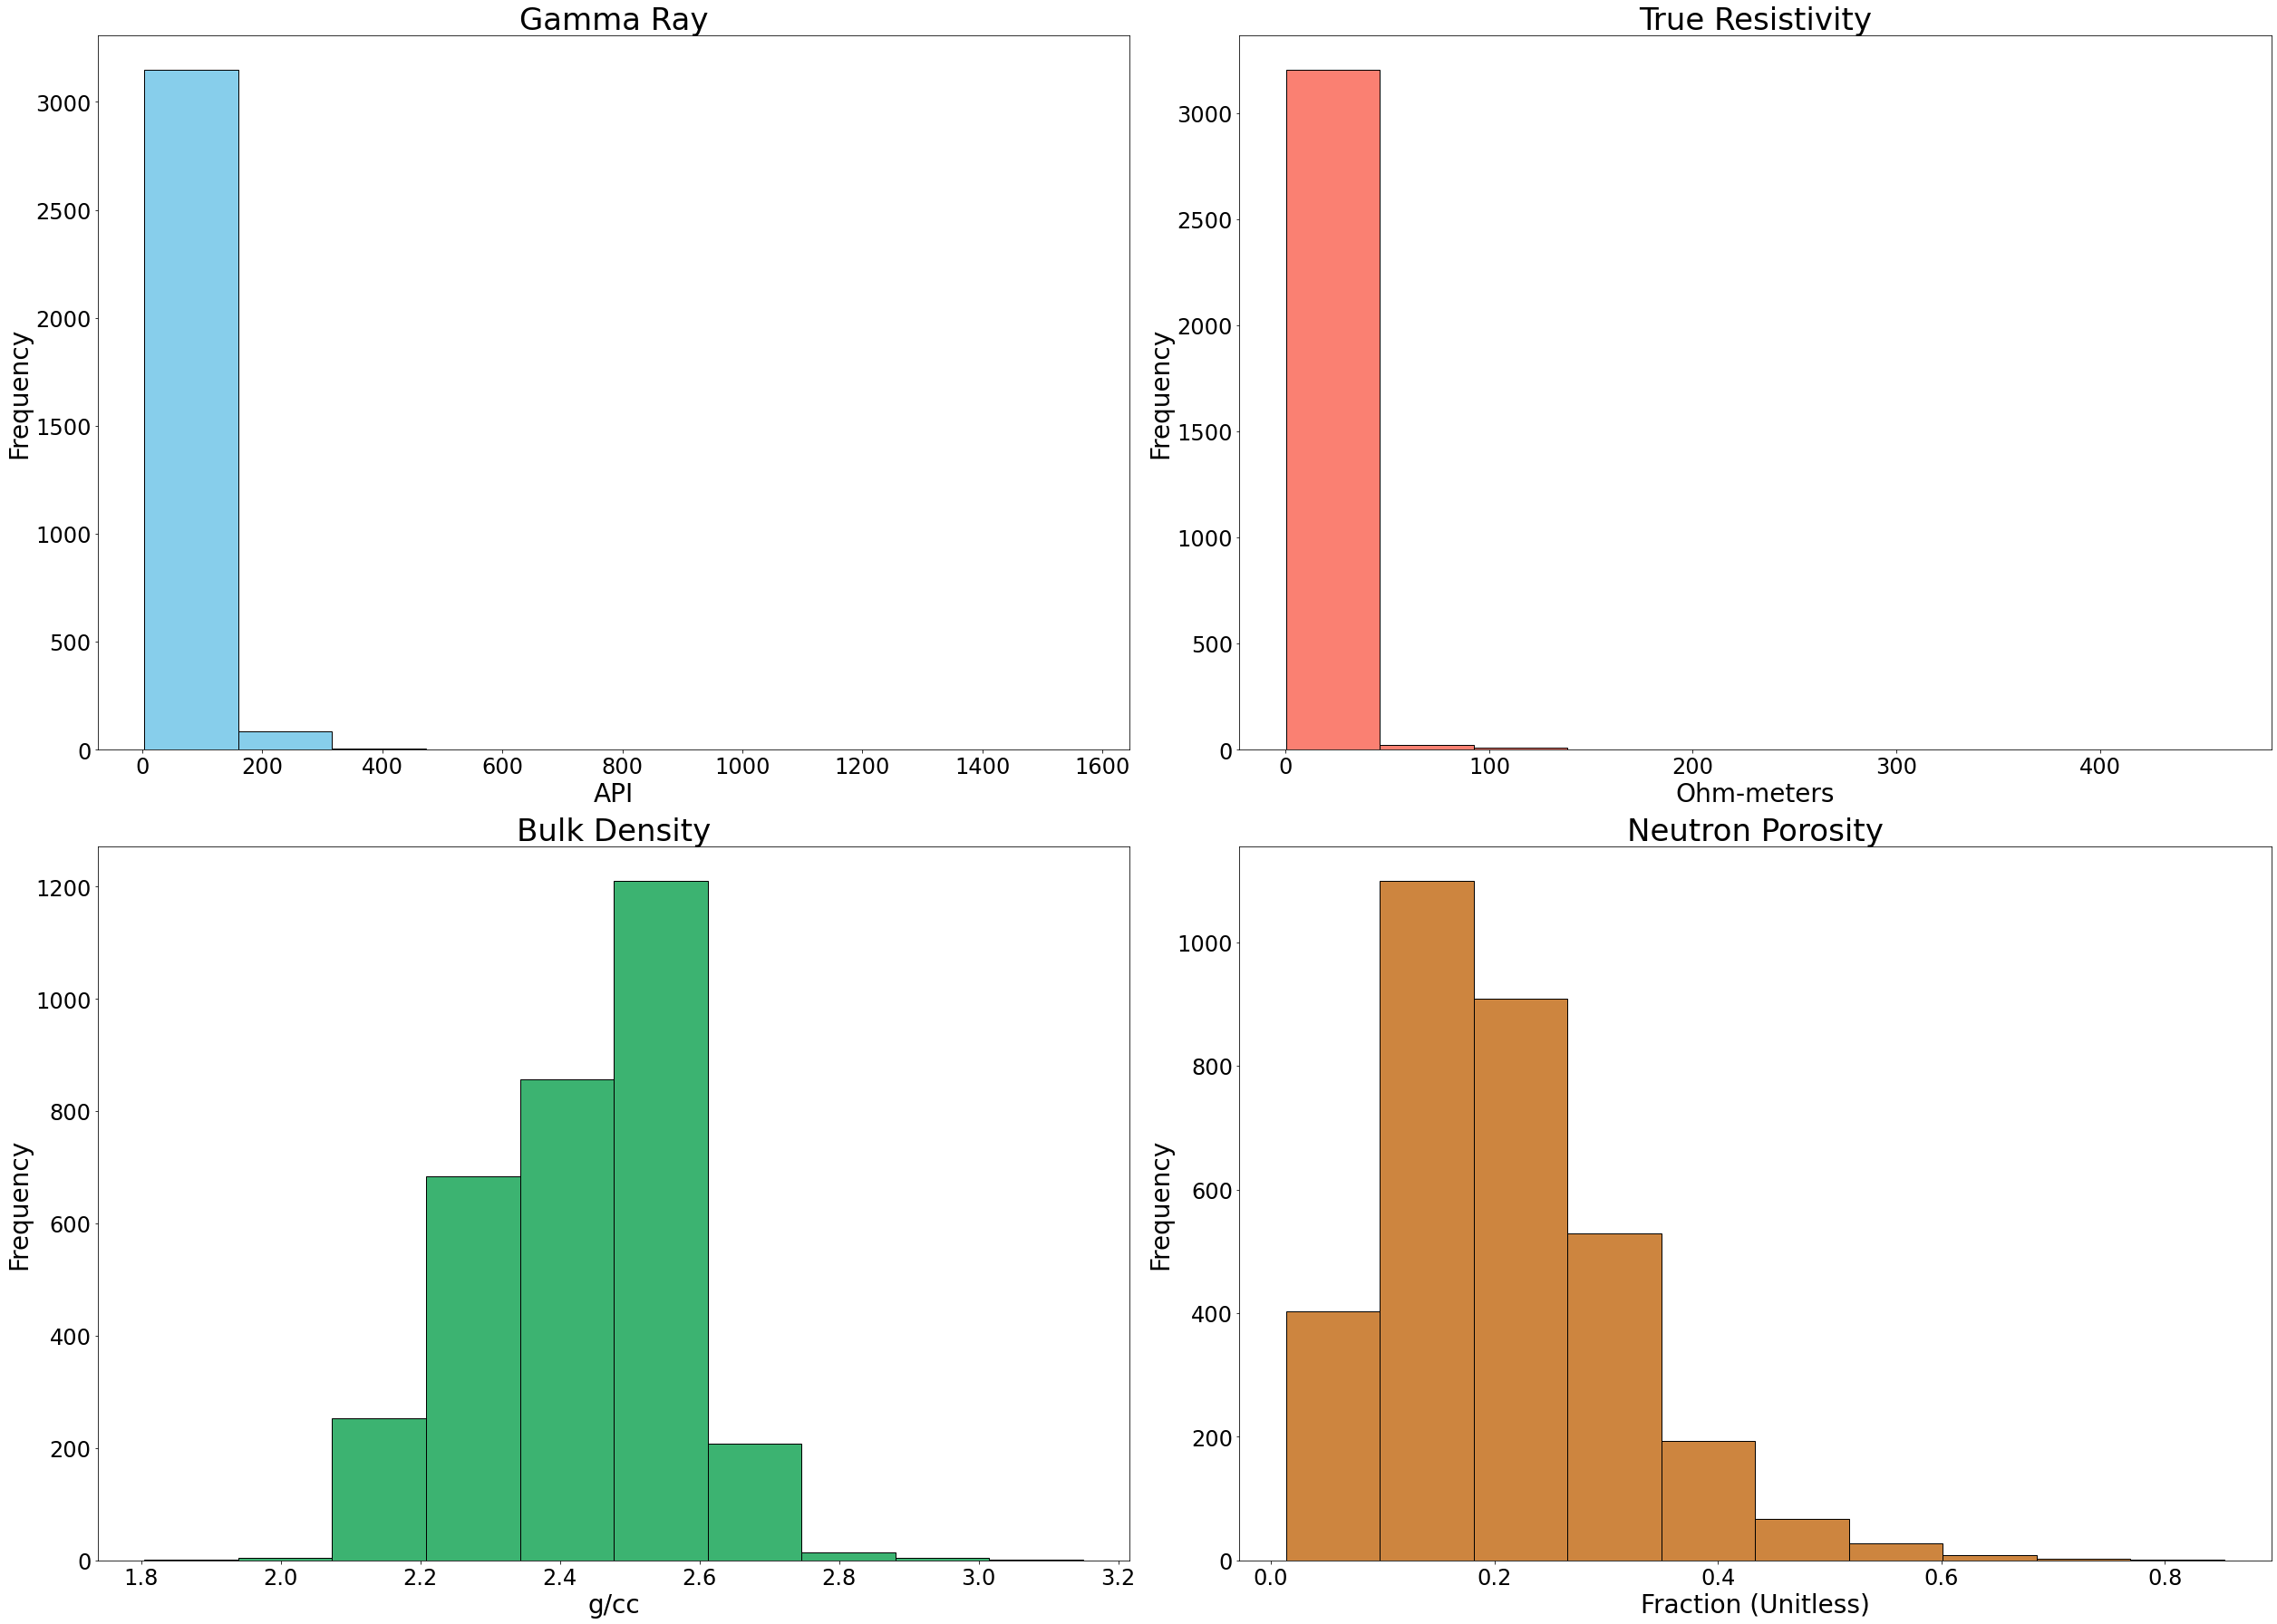

In [10]:
fig, axs = plt.subplots(2,2,figsize=(35,25))

axs[0, 0].hist(df['GR'], bins=10, color='skyblue', edgecolor='black')
axs[0, 0].set_title('Gamma Ray',fontsize=34)
axs[0, 0].set_xlabel('API',fontsize=28)
axs[0, 0].set_ylabel('Frequency',fontsize=28)
axs[0,0].tick_params(axis='both', which='major', labelsize=24)

axs[0, 1].hist(df['RT'], bins=10, color='salmon', edgecolor='black')
axs[0, 1].set_title('True Resistivity',fontsize=34)
axs[0, 1].set_xlabel('Ohm-meters',fontsize=28)
axs[0, 1].set_ylabel('Frequency',fontsize=28)
axs[0,1].tick_params(axis='both', which='major', labelsize=24)

axs[1, 0].hist(df['RHOB'], bins=10, color='mediumseagreen', edgecolor='black')
axs[1, 0].set_title('Bulk Density',fontsize=34)
axs[1, 0].set_xlabel('g/cc',fontsize=28)
axs[1, 0].set_ylabel('Frequency',fontsize=28)
axs[1,0].tick_params(axis='both', which='major', labelsize=24)

axs[1, 1].hist(df['NPHI'], bins=10, color='peru', edgecolor='black')
axs[1, 1].set_title('Neutron Porosity',fontsize=34)
axs[1, 1].set_xlabel('Fraction (Unitless)',fontsize=28)
axs[1, 1].set_ylabel('Frequency',fontsize=28)
axs[1,1].tick_params(axis='both', which='major', labelsize=24)

plt.tight_layout()
plt.show()

We will log transform the Gamma Ray and Resistivity data to have a more normal distribution.

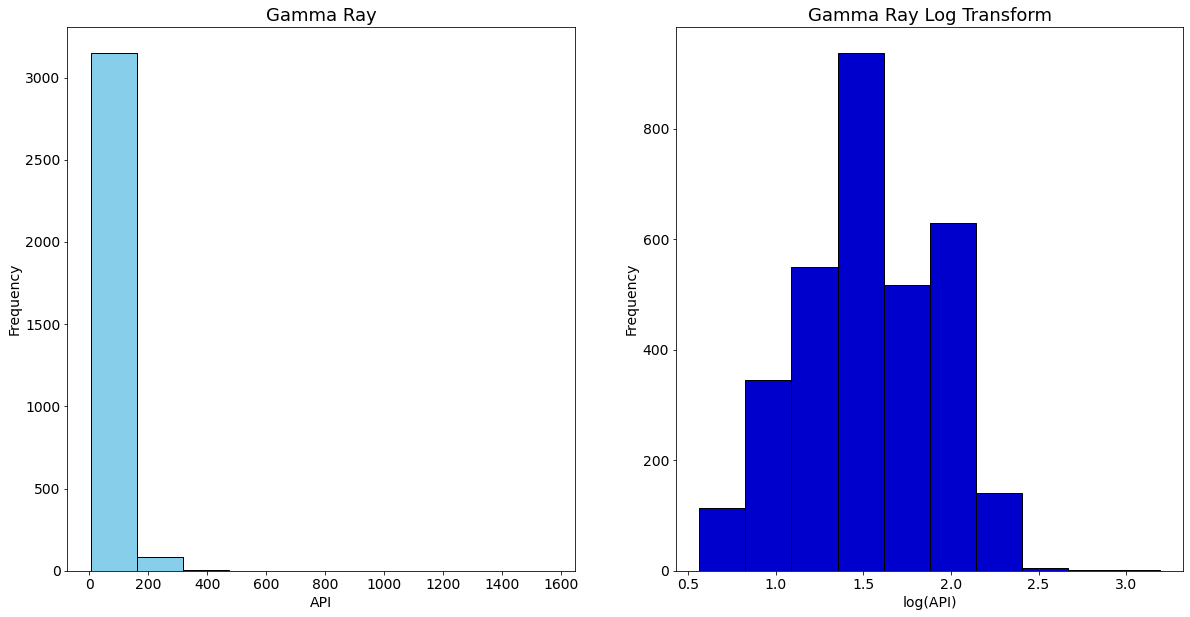

In [11]:
df['RT_log'] = np.log10(df.RT)
df['GR_log'] = np.log10(df.GR)


fig, axs = plt.subplots(1,2, figsize=(20,10))

axs[0].hist(df['GR'], bins=10, color='skyblue', edgecolor='black')
axs[0].set_title('Gamma Ray',fontsize=18)
axs[0].set_xlabel('API',fontsize=14)
axs[0].set_ylabel('Frequency',fontsize=14)
axs[0].tick_params(axis='both', which='major', labelsize=14)

axs[1].hist(df['GR_log'], bins=10, color='mediumblue', edgecolor='black')
axs[1].set_title('Gamma Ray Log Transform', fontsize=18)
axs[1].set_xlabel('log(API)', fontsize=14)
axs[1].set_ylabel('Frequency',fontsize=14)
axs[1].tick_params(axis='both', which='major', labelsize=14)

<Figure size 2160x1440 with 0 Axes>

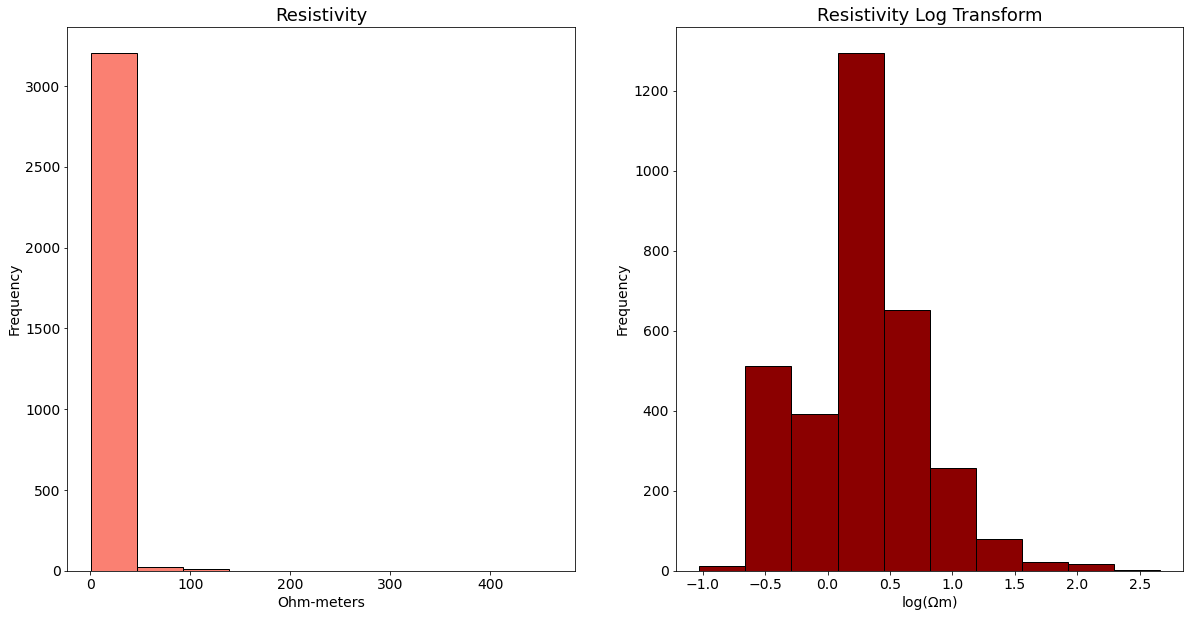

In [12]:
plt.figure(figsize=(30,20))
fig, axs = plt.subplots(1,2, figsize=(20,10))

axs[0].hist(df['RT'], bins=10, color='salmon', edgecolor='black')
axs[0].set_title('Resistivity',fontsize=18)
axs[0].set_xlabel('Ohm-meters',fontsize=14)
axs[0].set_ylabel('Frequency',fontsize=14)
axs[0].tick_params(axis='both', which='major', labelsize=14)

axs[1].hist(df['RT_log'], bins=10, color='darkred', edgecolor='black')
axs[1].set_title('Resistivity Log Transform', fontsize=18)
axs[1].set_xlabel('log(Ωm)', fontsize=14)
axs[1].set_ylabel('Frequency',fontsize=14)
axs[1].tick_params(axis='both', which='major', labelsize=14)

In [13]:
df.drop(['RT','GR'], inplace = True,axis = 1) # drop columns w/o transform
columns = df.columns.tolist()
columns.append(columns.pop(2))
df = df[columns]
df

,RHOB,NPHI,RT_log,GR_log,Facies
Depth,,,,,
3178.5,2.3296,0.3657,-0.230032,1.700868,SH
3179.0,2.3170,0.3776,-0.109691,1.674372,UN
3179.5,2.2960,0.5390,0.029668,1.694822,SH
3180.0,2.2514,0.5482,0.160168,1.652366,UN
3180.5,2.2733,0.5076,-0.020361,1.672142,UN
...,...,...,...,...,...
4083.5,2.4851,0.1416,0.245266,1.776018,CB
4084.0,2.4860,0.1416,0.217747,1.766539,CB
4084.5,2.5311,0.1527,0.203305,1.759660,CB


## Adding Features
We will add the calculated field, lithology density index, gamma ray index, and resistivity index which are geological parameters of the rocks.

In [14]:
df['LDI'] = df.eval('(GR_log-NPHI)/RHOB') #calculate lithology density index

columns = df.columns.tolist()
columns.append(columns.pop(4))
df = df[columns]
df.head()

,RHOB,NPHI,RT_log,GR_log,LDI,Facies
Depth,,,,,,
3178.5,2.3296,0.3657,-0.230032,1.700868,0.573132,SH
3179.0,2.3170,0.3776,-0.109691,1.674372,0.559677,UN
3179.5,2.2960,0.5390,0.029668,1.694822,0.503407,SH
3180.0,2.2514,0.5482,0.160168,1.652366,0.490435,UN
3180.5,2.2733,0.5076,-0.020361,1.672142,0.512269,UN


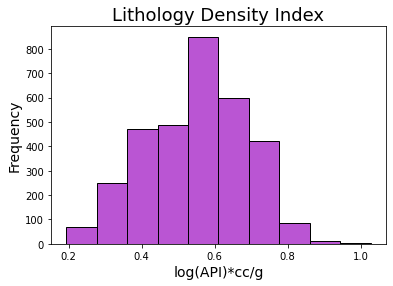

In [15]:
#fig, axs = plt.subplots(1,1, figsize=(25,8))

plt.hist(df['LDI'], bins=10, color='mediumorchid', edgecolor='black')
#axs[0].tick_params(axis='both', which='major', labelsize=14)

plt.title('Lithology Density Index',fontsize=18)
plt.xlabel('log(API)*cc/g',fontsize=14)
plt.ylabel('Frequency',fontsize=14)
plt.show()

# Data Analysis

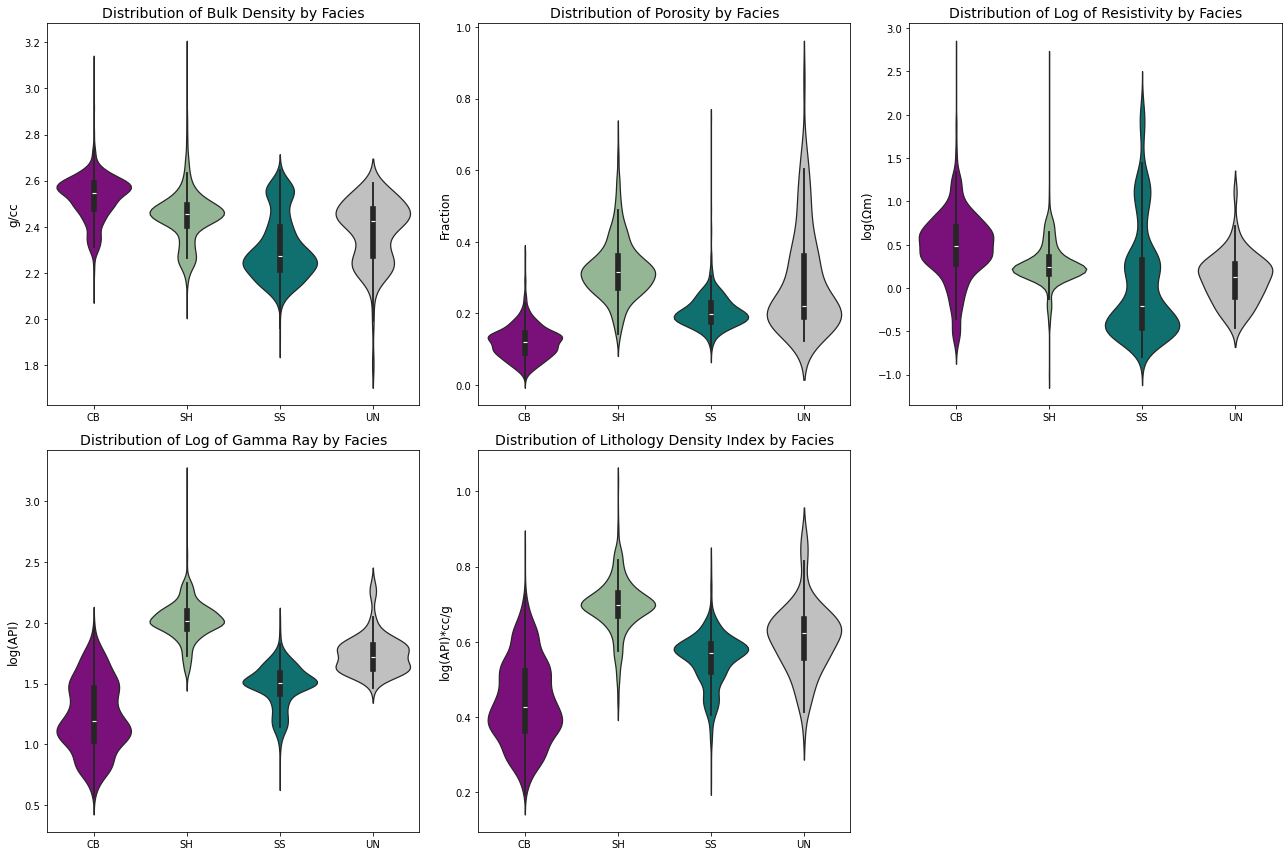

In [16]:
color_pal = {'SH':'darkseagreen', 'SS':'teal','UN':'silver','CB':'darkmagenta'}

plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
sns.violinplot(data=df, x='Facies', y='RHOB',hue='Facies',palette=color_pal,order=['CB','SH','SS','UN'])
plt.title('Distribution of Bulk Density by Facies', fontsize=14)
plt.ylabel('g/cc', fontsize=12)
plt.xlabel('')  # Remove the xlabel

plt.subplot(2, 3, 2)
sns.violinplot(data=df, x='Facies', y='NPHI',hue='Facies',palette=color_pal,order=['CB','SH','SS','UN'])
plt.title('Distribution of Porosity by Facies', fontsize=14)
plt.ylabel('Fraction', fontsize=12)
plt.xlabel('')  # Remove the xlabel

plt.subplot(2, 3, 3)
sns.violinplot(data=df, x='Facies', y='RT_log',hue='Facies',palette=color_pal,order=['CB','SH','SS','UN'])
plt.title('Distribution of Log of Resistivity by Facies', fontsize=14)
plt.ylabel('log(Ωm)', fontsize=12)
plt.xlabel('')  # Remove the xlabel

plt.subplot(2, 3, 4)
sns.violinplot(data=df, x='Facies', y='GR_log',hue='Facies',palette=color_pal,order=['CB','SH','SS','UN'])
plt.title('Distribution of Log of Gamma Ray by Facies', fontsize=14)
plt.ylabel('log(API)', fontsize=12)
plt.xlabel('')  # Remove the xlabel

plt.subplot(2, 3, 5)
sns.violinplot(data=df, x='Facies', y='LDI',hue='Facies',palette=color_pal,order=['CB','SH','SS','UN'])
plt.title('Distribution of Lithology Density Index by Facies', fontsize=14)
plt.ylabel('log(API)*cc/g', fontsize=12)
plt.xlabel('')  # Remove the xlabel

plt.tight_layout()
plt.show()

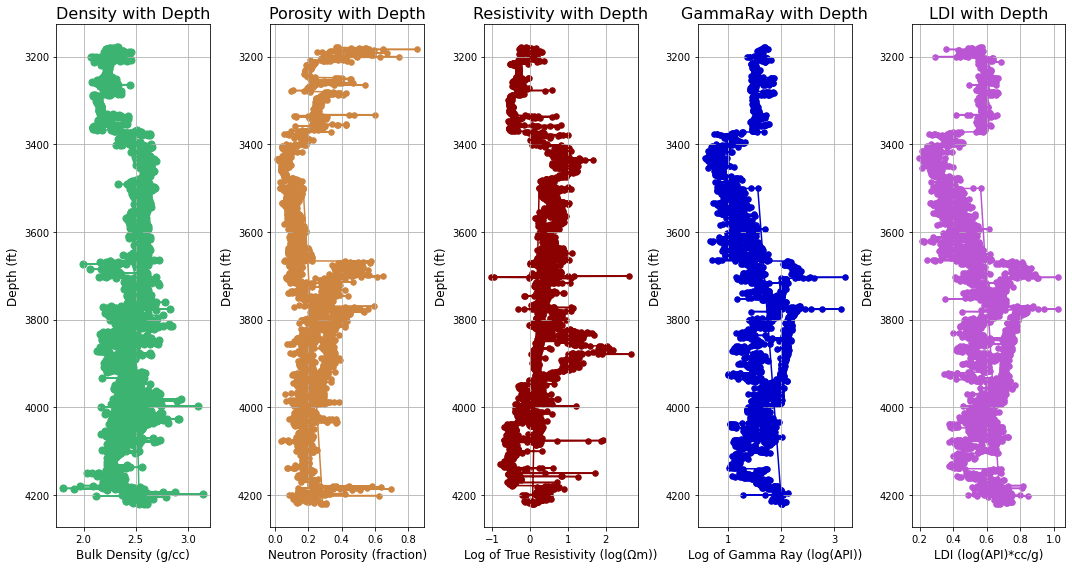

In [17]:
# Plot for Duration of Song
plt.figure(figsize=(15, 8))

plt.subplot(1, 5, 1)
plt.scatter(df['RHOB'], df.index, color='mediumseagreen', s=50)
plt.plot(df['RHOB'], df.index, color='mediumseagreen')
plt.xlabel('Bulk Density (g/cc)',fontsize=12)
plt.ylabel('Depth (ft)', fontsize=12)
plt.title('Density with Depth', fontsize=16)
plt.grid(True)
plt.gca().invert_yaxis()

plt.subplot(1, 5, 2)
plt.scatter(df['NPHI'], df.index, color='peru', s=30)
plt.plot(df['NPHI'], df.index, color='peru')
plt.xlabel('Neutron Porosity (fraction)',fontsize=12)
plt.ylabel('Depth (ft)', fontsize=12)
plt.title('Porosity with Depth', fontsize=16)
plt.grid(True)
plt.gca().invert_yaxis()

plt.subplot(1, 5, 3)
plt.scatter(df['RT_log'], df.index, color='darkred', s=30)
plt.plot(df['RT_log'], df.index, color='darkred')
plt.xlabel('Log of True Resistivity (log(Ωm))',fontsize=12)
plt.ylabel('Depth (ft)', fontsize=12)
plt.title('Resistivity with Depth', fontsize=16)
plt.grid(True)
plt.gca().invert_yaxis()

plt.subplot(1, 5, 4)
plt.scatter(df['GR_log'], df.index, color='mediumblue', s=30)
plt.plot(df['GR_log'], df.index, color='mediumblue')
plt.xlabel('Log of Gamma Ray (log(API))',fontsize=12)
plt.ylabel('Depth (ft)', fontsize=12)
plt.title('GammaRay with Depth', fontsize=16)
plt.grid(True)
plt.gca().invert_yaxis()

plt.subplot(1, 5, 5)
plt.scatter(df['LDI'], df.index, color='mediumorchid', s=30)
plt.plot(df['LDI'], df.index, color='mediumorchid')
plt.xlabel('LDI (log(API)*cc/g)',fontsize=12)
plt.ylabel('Depth (ft)', fontsize=12)
plt.title('LDI with Depth', fontsize=16)
plt.grid(True)
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

We can see that for each parameter, there is variation and not a single clear relationship with depth. Now we will see if there are clear relationships between the measured properties.

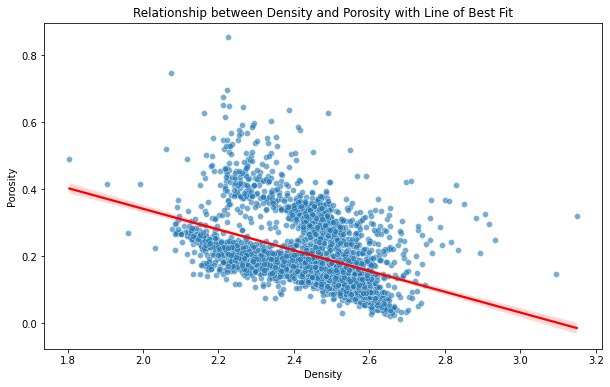

The line of best fit has a slope of -0.31
So there is no strong correlation between these two parameters


In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='RHOB', y='NPHI', alpha=0.6)
sns.regplot(data=df, x='RHOB', y='NPHI', scatter=False, color='red')

# Calculate the slope of the line
slope, intercept, r_value, p_value, std_err = linregress(df['RHOB'], df['NPHI'])

plt.title('Relationship between Density and Porosity with Line of Best Fit')
plt.xlabel('Density')
plt.ylabel('Porosity')
plt.show()

# Display the slope of the line, formatted to 2 decimals
print(f"The line of best fit has a slope of {slope:.2f}")
print("So there is no strong correlation between these two parameters")

We see a a general trend that as density increases, porosity decreases. This is inline with what we expect as an increase in density would increase overburden pressure, thus closing pore space and reducing porosity.

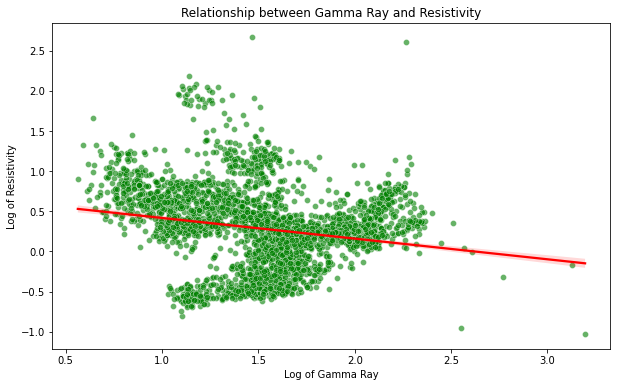

The line of best fit has a slope of -0.26
So there is no strong correlation between these two parameters


In [19]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='GR_log', y='RT_log', alpha=0.6, color='green')
sns.regplot(data=df, x='GR_log', y='RT_log', scatter=False, color='red')

# Calculate the slope of the line
slope, intercept, r_value, p_value, std_err = linregress(df['GR_log'], df['RT_log'])

plt.title('Relationship between Gamma Ray and Resistivity')
plt.xlabel('Log of Gamma Ray')
plt.ylabel('Log of Resistivity')
plt.show()

# Display the slope of the line, formatted to 2 decimals
print(f"The line of best fit has a slope of {slope:.2f}")
print("So there is no strong correlation between these two parameters")

There is not a clear relationship between resistivity and gamma ray which is to be expected as different properties of the rock affect the respective paramters graphed above. Instead we will look at the density of these properties.

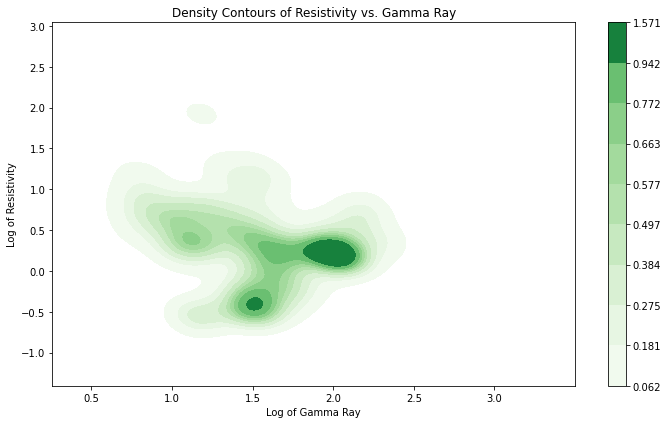

In [20]:
plt.figure(figsize=(10, 6))

sns.kdeplot(data=df, x="GR_log", y="RT_log", cmap="Greens", fill=True, thresh=0.05, cbar=True)

plt.title("Density Contours of Resistivity vs. Gamma Ray")
plt.xlabel("Log of Gamma Ray")
plt.ylabel("Log of Resistivity")
plt.tight_layout()

# Display the contour plot
plt.show()

While there is no strong linear relationship between resistivity and gamma ray measurements, there are a few clusters where the data is most heavily concentrated.

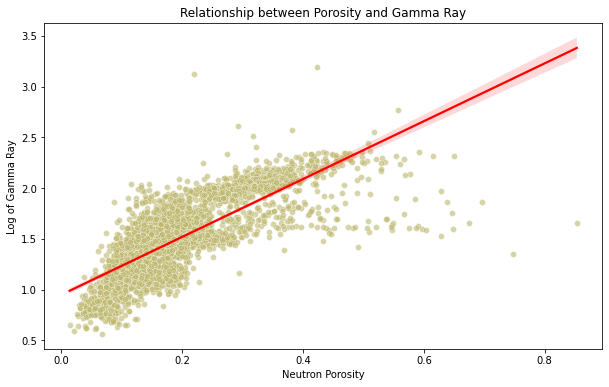

The line of best fit has a slope of 2.85
So there is no strong correlation between these two parameters


In [21]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='NPHI', y='GR_log', alpha=0.6, color='darkkhaki')
sns.regplot(data=df, x='NPHI', y='GR_log', scatter=False, color='red')

# Calculate the slope of the line
slope, intercept, r_value, p_value, std_err = linregress(df['NPHI'], df['GR_log'])

plt.title('Relationship between Porosity and Gamma Ray')
plt.xlabel('Neutron Porosity')
plt.ylabel('Log of Gamma Ray')
plt.show()

# Display the slope of the line, formatted to 2 decimals
print(f"The line of best fit has a slope of {slope:.2f}")
print("So there is no strong correlation between these two parameters")

There is a strong correlation between porosity and gamma ray. This is in line with expectations as a higher porosity means there is more empty space in the rock matrix and will therefore allow more gamma radiation to penetrate through.

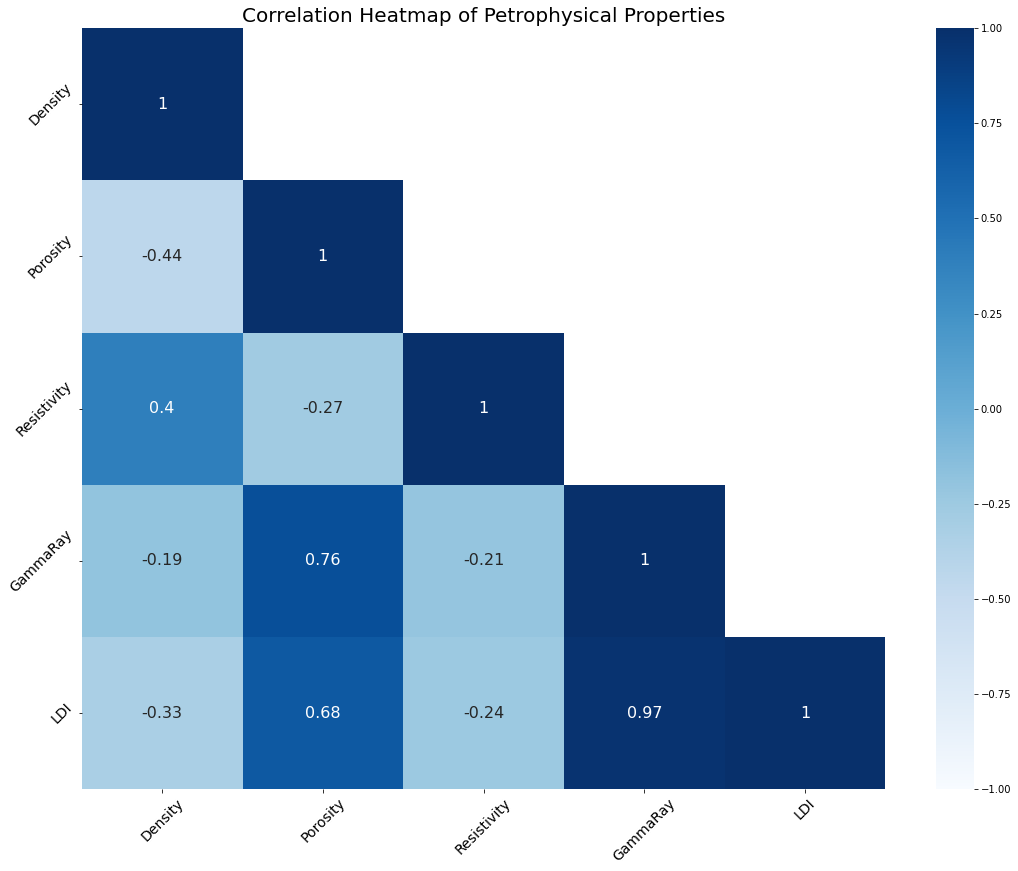

In [22]:
corr_df = df.drop(["Facies"], axis = 1).corr(method = "pearson")
variable_names = ['Density', 'Porosity', 'Resistivity', 'GammaRay','LDI']
corr_df.columns = variable_names
corr_df.index = variable_names

mask = np.zeros_like(corr_df, dtype=bool)
mask[np.triu_indices_from(mask)] = True
np.fill_diagonal(mask, False)

plt.figure(figsize=(18, 14))
ax = sns.heatmap(corr_df, annot=True, fmt=".2g", vmin=-1, vmax=1, center=0, cmap="Blues", mask=mask, annot_kws={"size": 16})
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.title("Correlation Heatmap of Petrophysical Properties", fontsize=20)

# Rotate the axis labels for better readability
plt.xticks(rotation=45, fontsize=14)
plt.yticks(rotation=45, fontsize=14)

# Show the plot
plt.show()

The correlation heatmap ranges from 1 to -1 where values closer to 0 indicate no linear trend between the two variables. Values closer to 1 indicate a stronger relationship and the same goes for values closer to -1, however, it indicates that one variable is increasing while the other is decreasing. Fore example, we can see that Density has the least relationship with GammaRay, porosity's relationship with resistivity is low as well.

## Split the Dataset into Train Test
Now we will begin to build the faciers classifiers

In [23]:
df.head()

,RHOB,NPHI,RT_log,GR_log,LDI,Facies
Depth,,,,,,
3178.5,2.3296,0.3657,-0.230032,1.700868,0.573132,SH
3179.0,2.3170,0.3776,-0.109691,1.674372,0.559677,UN
3179.5,2.2960,0.5390,0.029668,1.694822,0.503407,SH
3180.0,2.2514,0.5482,0.160168,1.652366,0.490435,UN
3180.5,2.2733,0.5076,-0.020361,1.672142,0.512269,UN


In [24]:
data=df.values
data.shape
X = data[:,:5]
y = data[:,5]

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=4, train_size=0.75)

## Checking for ouliers

Isolation forest represents an unsupervised anomaly detection algorithm which detects outliers in datasets with hgih speeds, this algoriithm is powerful and scalable for identifiying outliers in data.

In [26]:
from sklearn.ensemble import IsolationForest
out = IsolationForest(contamination = 0.05, max_samples = 0.8, max_features=1.0)
out.fit(X_train)
in_out=out.predict(X_train)
in_out

array([1, 1, 1, ..., 1, 1, 1])

In [27]:
X_train_i = X_train[in_out==1]
y_train_i = y_train[in_out==1]

In [28]:
X_test_i =X_test[out.predict(X_test)==1]
y_test_i =y_test[out.predict(X_test)==1]

## Scaling

StandardScaler removes the mean and scales each feature to unit variance. Because it can be influenced by outliers (since it invloves estimation of mean and standard deviation), then we perform standardscaling after outlier removal

In [29]:
from sklearn.preprocessing import StandardScaler
scl= StandardScaler()
scl.fit(X_train_i)
X_train_i_s=scl.transform(X_train_i)
X_test_i_s=scl.transform(X_test_i)

## Association Check (F-test and Mutual Information)

The difference between F-test and Mutual Information and the reason why they are usually performed together is that F-test captures linear dependency only while MI can capture any kind of dependency between variables.

In [30]:
from sklearn.feature_selection import f_classif, mutual_info_classif

f_scores, p_values = f_classif(X_train_i_s, y_train_i)
mi_scores = mutual_info_classif(X_train_i_s, y_train_i)

In [31]:
columns = df.columns[:-1].tolist()
association_df = pd.DataFrame({'Feature':columns, 'F_score':f_scores, 'MI_Score': mi_scores})
association_df

,Feature,F_score,MI_Score
0,RHOB,486.989506,0.320847
1,NPHI,1637.863329,0.622237
2,RT_log,148.505747,0.303794
3,GR_log,1656.339967,0.642662
4,LDI,1123.945092,0.546430


## Hyperparameter Tuning
We will use grid search to more quickly test out several parameters and find the best model for each method.

In [32]:
lr_param_grid = {'C': [0.1, 1, 10],'penalty': ['l1', 'l2']}

kn_param_grid = {'n_neighbors': [3, 5, 7],'weights': ['uniform', 'distance']}

gb_param_grid = {'n_estimators': [50, 100, 200],'learning_rate': [0.01, 0.1, 0.2]}

ab_param_grid = {'n_estimators': [50, 100, 200],'learning_rate': [0.01, 0.1, 0.2]}

gn_param_grid = {}  # No hyperparameters to tune

sv_param_grid = {'C': [0.1, 1, 10],'kernel': ['linear', 'rbf']}

rf_param_grid = {'n_estimators': [50, 100, 200],'max_depth': [None, 10, 20]}

nn_param_grid = {'hidden_layer_sizes': [(100,), (100, 50), (50, 50, 50)],'alpha': [0.0001, 0.001, 0.01]}

## Logistic Regression

Supervised ML algorithm used for binary calssification tasks which relates to our question definition of developing classifiers for lithology. We aim to find the best performing model in the task of classification.

In [33]:
lr = LogisticRegression(max_iter=1000)

lr_grid = GridSearchCV(lr, lr_param_grid, cv=5, n_jobs=-1)
lr_grid.fit(X_train_i_s, y_train_i)

lr_best_params = lr_grid.best_params_
print('Logistic regression classifier best hyperparameters:', lr_best_params)

Logistic regression classifier best hyperparameters: {'C': 10, 'penalty': 'l2'}


C:\Users\19152\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
15 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\19152\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\19152\anaconda3\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\19152\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)

In [34]:
lr_best_model = lr_grid.best_estimator_
lr_preds = lr_best_model.predict(X_test_i_s)

In [35]:
print('Memorization performance: ', lr_grid.score(X_train_i_s,y_train_i))
print('Generalization performance: ', lr_grid.score(X_test_i_s,y_test_i))

Memorization performance:  0.8570190641247833
Generalization performance:  0.8541666666666666


Memorization is the ability of deep models to associate training data with random variables. Generalization shows how the model performs in classification. The scores are relatively low.

In [36]:
from sklearn.metrics import roc_auc_score
y_score = lr_best_model.fit(X_train_i_s, y_train_i).predict_proba(X_test_i_s)
auc_lr = roc_auc_score(y_test_i, y_score, multi_class='ovo', average='weighted')
f1_lr = f1_score(y_test_i, lr_preds, average='weighted')
mcc_lr = matthews_corrcoef(y_test_i, lr_preds)

In [37]:
rank = []

rank.append(tuple(('LR', auc_lr, f1_lr, mcc_lr)))

# K-Nearest Neighbor Classifier

KNN is another supervised learning classifier that uses proximity to make classifications about grouping of an individiual data point

In [38]:
knn = KNeighborsClassifier()

knn_grid = GridSearchCV(knn, kn_param_grid, cv=5, n_jobs=-1)
knn_grid.fit(X_train_i_s, y_train_i)

knn_best_params = knn_grid.best_params_
print('KNN classifier best hyperparameters:', knn_best_params)

KNN classifier best hyperparameters: {'n_neighbors': 7, 'weights': 'distance'}


In [39]:
knn_best_model = knn_grid.best_estimator_
knn_preds = knn_best_model.predict(X_test_i_s)

In [40]:
print('Memorization performance: ', knn_grid.score(X_train_i_s,y_train_i))
print('Generalization performance: ', knn_grid.score(X_test_i_s,y_test_i))

Memorization performance:  1.0
Generalization performance:  0.8619791666666666


Generalization performance of KNN is lower than that of Logistic Regression

In [41]:
from sklearn.metrics import roc_auc_score
y_score = knn_best_model.fit(X_train_i_s, y_train_i).predict_proba(X_test_i_s)
auc_knn = roc_auc_score(y_test_i, y_score, multi_class='ovo', average='weighted')
f1_knn = f1_score(y_test_i, knn_preds, average='weighted')
mcc_knn = matthews_corrcoef(y_test_i, knn_preds)

rank.append(tuple(('KNN', auc_knn, f1_knn, mcc_knn)))

## Gradient Boosting Classifier

A functional gradient algorithm that loops in selecting a function that leads in the direction of a negative gradient to minimize loss function

In [42]:
gb = GradientBoostingClassifier()

gb_grid = GridSearchCV(gb, gb_param_grid, cv=5, n_jobs=-1)
gb_grid.fit(X_train_i_s, y_train_i)

gb_best_params = gb_grid.best_params_
print('GB classifier best hyperparameters:', gb_best_params)

GB classifier best hyperparameters: {'learning_rate': 0.1, 'n_estimators': 100}


In [43]:
gb_best_model = gb_grid.best_estimator_
gb_preds = gb_best_model.predict(X_test_i_s)

In [44]:
print('Memorization performance: ', gb_grid.score(X_train_i_s,y_train_i))
print('Generalization performance: ', gb_grid.score(X_test_i_s,y_test_i))

Memorization performance:  0.9597053726169844
Generalization performance:  0.8684895833333334


Similar performance to logistics regression and KNN

In [45]:
from sklearn.metrics import roc_auc_score
y_score = gb_best_model.fit(X_train_i_s, y_train_i).predict_proba(X_test_i_s)
auc_gb = roc_auc_score(y_test_i, y_score, multi_class='ovo', average='weighted')
f1_gb = f1_score(y_test_i, gb_preds, average='weighted')
mcc_gb = matthews_corrcoef(y_test_i, gb_preds)

rank.append(tuple(('GB', auc_gb, f1_gb, mcc_gb)))

## Adaboost Classifier

the first designed boosting algorithm with certain loss function while gradient boosting is a basic algorithm that helps in searching approximate soltuions.

In [46]:
ab = AdaBoostClassifier()

ab_grid = GridSearchCV(ab, ab_param_grid, cv=5, n_jobs=-1)
ab_grid.fit(X_train_i_s, y_train_i)

ab_best_params = ab_grid.best_params_
print('AB classifier best hyperparameters:', ab_best_params)

AB classifier best hyperparameters: {'learning_rate': 0.1, 'n_estimators': 100}


In [47]:
ab_best_model = ab_grid.best_estimator_
ab_preds = ab_best_model.predict(X_test_i_s)

In [48]:
print('Memorization performance: ', ab_grid.score(X_train_i_s,y_train_i))
print('Generalization performance: ', ab_grid.score(X_test_i_s,y_test_i))

Memorization performance:  0.8678509532062392
Generalization performance:  0.8385416666666666


Somewhat better generalization performance compared to logistic regression, KNN, and gradient boosting

In [49]:
from sklearn.metrics import roc_auc_score
y_score = ab_best_model.fit(X_train_i_s, y_train_i).predict_proba(X_test_i_s)
auc_ab = roc_auc_score(y_test_i, y_score, multi_class='ovo', average='weighted')
f1_ab = f1_score(y_test_i, ab_preds, average='weighted')
mcc_ab = matthews_corrcoef(y_test_i, ab_preds)

rank.append(tuple(('AB', auc_ab, f1_ab, mcc_ab)))

## Gaussian Naive Bayes Classifier

ML classifier based on probablistic approach which asssumes each class follows a normal distribution

In [50]:
gn = GaussianNB()

gn_grid = GridSearchCV(gn, gn_param_grid, cv=5, n_jobs=-1)
gn_grid.fit(X_train_i_s, y_train_i)

gn_best_params = gn_grid.best_params_
print('GN classifier best hyperparameters:', gn_best_params)

GN classifier best hyperparameters: {}


In [51]:
gn_best_model = gn_grid.best_estimator_
gn_preds = gn_best_model.predict(X_test_i_s)

In [52]:
print('Memorization performance: ', gn_grid.score(X_train_i_s,y_train_i))
print('Generalization performance: ', gn_grid.score(X_test_i_s,y_test_i))

Memorization performance:  0.8266897746967071
Generalization performance:  0.8216145833333334


Similar results and no major changes

In [53]:
from sklearn.metrics import roc_auc_score
y_score = gn_best_model.fit(X_train_i_s, y_train_i).predict_proba(X_test_i_s)
auc_gn = roc_auc_score(y_test_i, y_score, multi_class='ovo', average='weighted')
f1_gn = f1_score(y_test_i, gn_preds, average='weighted')
mcc_gn = matthews_corrcoef(y_test_i, gn_preds)

rank.append(tuple(('GN', auc_gn, f1_gn, mcc_gn)))

## Support Vector Classifier

Supervised learning algorithm used in ML to solve binary classification problems

In [54]:
sv = SVC(probability=True)

sv_grid = GridSearchCV(sv, sv_param_grid, cv=5, n_jobs=-1)
sv_grid.fit(X_train_i_s, y_train_i)

sv_best_params = sv_grid.best_params_
print('SVC best hyperparameters:', sv_best_params)

SVC best hyperparameters: {'C': 10, 'kernel': 'rbf'}


In [55]:
sv_best_model = sv_grid.best_estimator_
sv_preds = sv_best_model.predict(X_test_i_s)

In [56]:
print('Memorization performance: ', sv_grid.score(X_train_i_s,y_train_i))
print('Generalization performance: ', sv_grid.score(X_test_i_s,y_test_i))

Memorization performance:  0.8990467937608319
Generalization performance:  0.87890625


This method yields similar performance scores to the previous models

In [57]:
y_score = sv_best_model.fit(X_train_i_s, y_train_i).predict_proba(X_test_i_s)
auc_sv = roc_auc_score(y_test_i, y_score, multi_class='ovo', average='weighted')
f1_sv = f1_score(y_test_i, sv_preds, average='weighted')
mcc_sv = matthews_corrcoef(y_test_i, sv_preds)

rank.append(tuple(('SVR', auc_sv, f1_sv, mcc_sv)))

## Random Forest Classifier

This classifier adds additional randomness to the model while growing trees to search for the best feature among a random subset of features

In [58]:
rf = RandomForestClassifier()

rf_grid = GridSearchCV(rf, rf_param_grid, cv=5, n_jobs=-1)
rf_grid.fit(X_train_i_s, y_train_i)

rf_best_params = rf_grid.best_params_
print('RF Classifier best hyperparameters:', rf_best_params)

RF Classifier best hyperparameters: {'max_depth': None, 'n_estimators': 200}


In [59]:
rf_best_model = rf_grid.best_estimator_
rf_preds = rf_best_model.predict(X_test_i_s)

In [60]:
print('Memorization performance: ', rf_grid.score(X_train_i_s,y_train_i))
print('Generalization performance: ', rf_grid.score(X_test_i_s,y_test_i))

Memorization performance:  1.0
Generalization performance:  0.8776041666666666


higher memorization performance is displayed wile the generalization performance is decreased compared to previous models. Could be due to hyperparameters not properly tuned

In [61]:
y_score = rf_best_model.fit(X_train_i_s, y_train_i).predict_proba(X_test_i_s)
auc_rf = roc_auc_score(y_test_i, y_score, multi_class='ovo', average='weighted')
f1_rf = f1_score(y_test_i, rf_preds, average='weighted')
mcc_rf = matthews_corrcoef(y_test_i, rf_preds)

rank.append(tuple(('RF', auc_rf, f1_rf, mcc_rf)))

## Neural Network Classifier MLP

Helps in clustering and classifying

In [62]:
nn = MLPClassifier()

nn_grid = GridSearchCV(nn, nn_param_grid, cv=5, n_jobs=-1)
nn_grid.fit(X_train_i_s, y_train_i)

nn_best_params = nn_grid.best_params_
print('NN Classifier best hyperparameters:', nn_best_params)

NN Classifier best hyperparameters: {'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


C:\Users\19152\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [63]:
nn_best_model = nn_grid.best_estimator_
nn_preds = nn_best_model.predict(X_test_i_s)

In [64]:
print('Memorization performance: ', nn_grid.score(X_train_i_s,y_train_i))
print('Generalization performance: ', nn_grid.score(X_test_i_s,y_test_i))

Memorization performance:  0.9003466204506065
Generalization performance:  0.875


Results are similar to those of previous models

In [65]:
y_score = nn_best_model.fit(X_train_i_s, y_train_i).predict_proba(X_test_i_s)
auc_nn = roc_auc_score(y_test_i, y_score, multi_class='ovo', average='weighted')
f1_nn = f1_score(y_test_i, nn_preds, average='weighted')
mcc_nn = matthews_corrcoef(y_test_i, nn_preds)

rank.append(tuple(('NN', auc_nn, f1_nn, mcc_nn)))

C:\Users\19152\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


## Comparing the different classifier models

In [66]:
df = pd.DataFrame(rank, columns =['Model', 'AUC', 'f1_score','Mathews Corr Coeff'])
df['Sum of Scores'] = df['AUC'] + df['f1_score'] + df['Mathews Corr Coeff']
df

,Model,AUC,f1_score,Mathews Corr Coeff,Sum of Scores
0,LR,0.961831,0.842649,0.784565,2.589045
1,KNN,0.953130,0.860467,0.797040,2.610637
2,GB,0.970042,0.865823,0.807688,2.643553
3,AB,0.879665,0.831634,0.763864,2.475163
4,GN,0.955245,0.829757,0.743757,2.528760
5,SVR,0.967925,0.878181,0.822689,2.668794
6,RF,0.971331,0.875659,0.820351,2.667342
7,NN,0.973190,0.872801,0.816205,2.662196


Area under the Curve handles class imbalance by setting multi_class to one vs one 'ovo' instead of one vs rest 'ovr'. The averaging performed method must not be 'macro' in order for ovo to handle class imablance, so we chose 'weighted'
F1 score - the averaging method is set to 'weighted' in order to handle class imbalance.
Matthews Correlation Coefficient - "is generally regarded as a balanced measure which can be used even if the classes are of very different sizes" from https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html

In [67]:
df.sort_values(by='Sum of Scores', ascending=False)

,Model,AUC,f1_score,Mathews Corr Coeff,Sum of Scores
5,SVR,0.967925,0.878181,0.822689,2.668794
6,RF,0.971331,0.875659,0.820351,2.667342
7,NN,0.973190,0.872801,0.816205,2.662196
2,GB,0.970042,0.865823,0.807688,2.643553
1,KNN,0.953130,0.860467,0.797040,2.610637
0,LR,0.961831,0.842649,0.784565,2.589045
4,GN,0.955245,0.829757,0.743757,2.528760
3,AB,0.879665,0.831634,0.763864,2.475163


Our three best classifiers are Support Vector Regressor, Random Forest, and the MLP Neural Networks. We will now try these three models on Well 13.

## Confusion Matrix

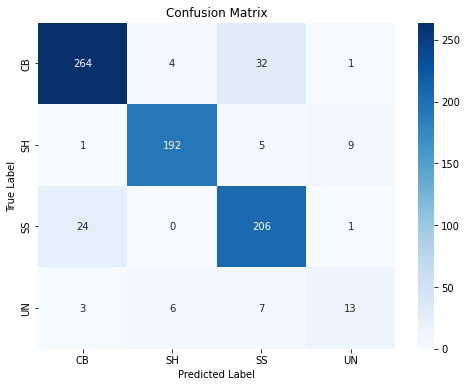

In [68]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
class_names = sv_best_model.classes_
cm = confusion_matrix(y_test_i, sv_preds, labels=class_names)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues',fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Carbonate (CB) is easiest to predict and the unclassified (UN) facies is hardest to predict. This is to be expected as unclassified would have features from other possible rock facies, but not clearly fit into a different type of lithology. The top performing model does have sometimes confuse sandstones (SS) for carbonates.

## Now we will predict the Well 13 facies
Using the top three models based on the test performance on wells 13 and 14

In [69]:
deploy=pd.read_excel('VolveData_Project.xlsx', sheet_name='well 13',index_col='Depth')
deploy.head()

,Well,GR,RT,RHOB,NPHI
Depth,,,,,
4175.5,13,20.6032,4.1812,2.6117,0.0770
4176.0,13,21.4990,4.5516,2.6131,0.0798
4176.5,13,22.4472,4.4804,2.6334,0.0801
4177.0,13,29.6713,4.3859,2.6328,0.1005
4177.5,13,34.7014,4.8566,2.6183,0.1001


In [70]:
df13=deploy.drop(columns=['Well'])
df13['RT_log'] = np.log10(df13.RT)
df13['GR_log'] = np.log10(df13.GR)
df13.drop(['RT','GR'], inplace = True,axis = 1)
df13['LDI'] = df13.eval('(GR_log-NPHI)/RHOB')
df13.head()

,RHOB,NPHI,RT_log,GR_log,LDI
Depth,,,,,
4175.5,2.6117,0.0770,0.621301,1.313935,0.473613
4176.0,2.6131,0.0798,0.658164,1.332418,0.479361
4176.5,2.6334,0.0801,0.651317,1.351162,0.482670
4177.0,2.6328,0.1005,0.642059,1.472337,0.521056
4177.5,2.6183,0.1001,0.686332,1.540347,0.550070


In [71]:
X = df13.to_numpy()

In [72]:
in_out = out.predict(X)
X_i = X[in_out==1]
X_is= scl.transform(X_i)

In [75]:
depth_vals = df13.index.values
depth_vals = depth_vals[in_out==1]

In [76]:
sv_predictions = sv_best_model.predict(X_is)
rf_predictions = rf_best_model.predict(X_is)
nn_predictions = nn_best_model.predict(X_is)

In [77]:
column_names = df13.columns.tolist()

X_preds = pd.DataFrame(X_i,columns = column_names )
X_preds['SVC Predictions'] = sv_predictions
X_preds['RF Predictions'] = rf_predictions
X_preds['NN Predictions'] = nn_predictions
X_preds['Depth'] = depth_vals
X_preds.set_index('Depth',inplace=True)
X_preds

,RHOB,NPHI,RT_log,GR_log,LDI,SVC Predictions,RF Predictions,NN Predictions
Depth,,,,,,,,
4175.5,2.6117,0.0770,0.621301,1.313935,0.473613,CB,CB,CB
4176.0,2.6131,0.0798,0.658164,1.332418,0.479361,CB,CB,CB
4176.5,2.6334,0.0801,0.651317,1.351162,0.482670,CB,CB,CB
4177.0,2.6328,0.1005,0.642059,1.472337,0.521056,CB,CB,CB
4177.5,2.6183,0.1001,0.686332,1.540347,0.550070,CB,CB,CB
...,...,...,...,...,...,...,...,...
4586.5,2.5219,0.1587,0.142296,1.833573,0.664131,UN,SH,CB
4587.0,2.5062,0.1739,0.139879,1.857066,0.671601,SH,SH,SH
4587.5,2.5030,0.1704,0.126813,1.829787,0.662959,UN,UN,UN


In [78]:
facies_colors = ['blue', 'green','yellow','orange']

facies_labels = ['Carbonate','Sandstone','Shale','Unclassfied']

facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]

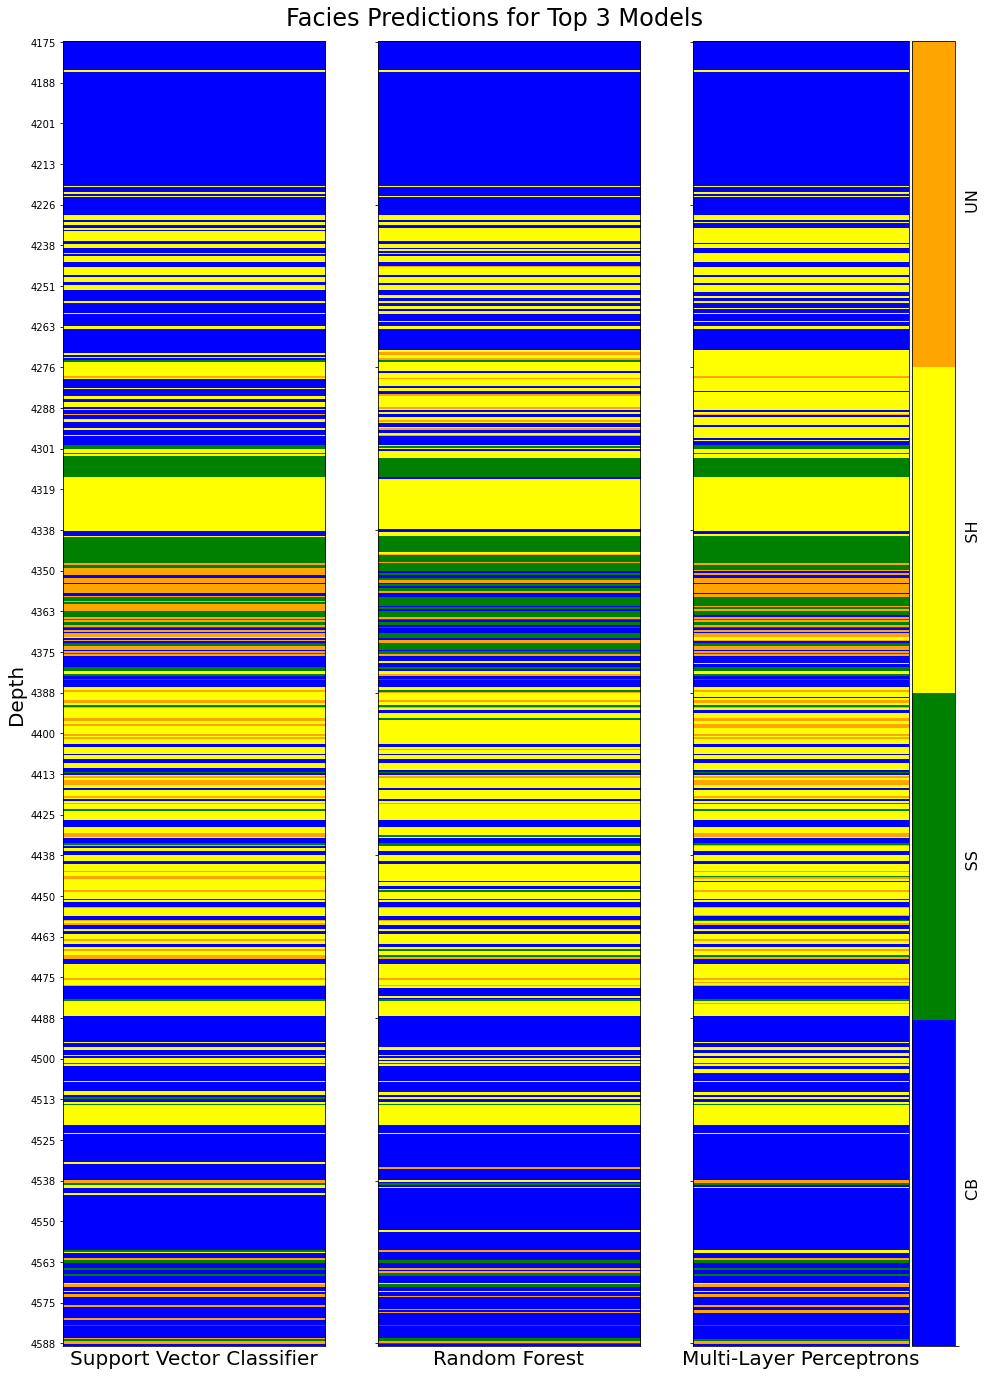

In [79]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colors

cmap_facies = colors.ListedColormap(
facies_color_map.values(), name = facies_color_map.keys())
ztop=4175.5; zbot=4588.5


cluster1 = np.repeat(np.expand_dims(X_preds['SVC Predictions'].astype('category').cat.codes.values,1), 100, 1)
cluster2 = np.repeat(np.expand_dims(X_preds['RF Predictions'].astype('category').cat.codes.values,1), 100, 1)
cluster3 = np.repeat(np.expand_dims(X_preds['NN Predictions'].astype('category').cat.codes.values,1), 100, 1)


f, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 24))
im = ax[0].imshow(cluster1, interpolation='none', aspect='auto', cmap=cmap_facies)
im = ax[1].imshow(cluster2, interpolation='none', aspect='auto', cmap=cmap_facies)
im = ax[2].imshow(cluster3, interpolation='none', aspect='auto', cmap=cmap_facies)

f.suptitle('Facies Predictions for Top 3 Models', fontsize=24,y=0.9)

divider = make_axes_locatable(ax[2])
cax = divider.append_axes("right", size="20%", pad=0.05)
cbar=plt.colorbar(im, cax=cax)
cbar.set_label((60 *' ').join(['CB','SS','SH','UN']),fontsize=16)
cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')

depth_axis = X_preds.index
ax[0].set_ylabel('Depth', fontsize=20)
ax[0].set_yticks(np.arange(0, len(depth_axis), 25))
ax[0].set_yticklabels(depth_axis[::25].astype(int))

ax[0].set_xlabel('Support Vector Classifier',fontsize=20)
ax[1].set_xlabel('Random Forest',fontsize=20)
ax[2].set_xlabel('Multi-Layer Perceptrons',fontsize=20)

ax[0].set_xticks([])
ax[1].set_xticks([])
ax[1].set_yticklabels([])
ax[2].set_xticks([])
ax[2].set_yticklabels([])

plt.show()

The graph displayes the three predicting models and they do have similar results. Accurate classification of facies is an important task in petroleum engineering and machine learning models if tuned correctly do a good job at predicting the different lithological layers

In [80]:
from collections import Counter

def most_common(df):
    for s in df.to_numpy():
        k, v = Counter(s).most_common(1)[0]
        yield '-' if v == 1 else k

X_preds['Most Common Prediction'] = list(most_common(X_preds.iloc[:,5:8]))
X_preds

,RHOB,NPHI,RT_log,GR_log,LDI,SVC Predictions,RF Predictions,NN Predictions,Most Common Prediction
Depth,,,,,,,,,
4175.5,2.6117,0.0770,0.621301,1.313935,0.473613,CB,CB,CB,CB
4176.0,2.6131,0.0798,0.658164,1.332418,0.479361,CB,CB,CB,CB
4176.5,2.6334,0.0801,0.651317,1.351162,0.482670,CB,CB,CB,CB
4177.0,2.6328,0.1005,0.642059,1.472337,0.521056,CB,CB,CB,CB
4177.5,2.6183,0.1001,0.686332,1.540347,0.550070,CB,CB,CB,CB
...,...,...,...,...,...,...,...,...,...
4586.5,2.5219,0.1587,0.142296,1.833573,0.664131,UN,SH,CB,-
4587.0,2.5062,0.1739,0.139879,1.857066,0.671601,SH,SH,SH,SH
4587.5,2.5030,0.1704,0.126813,1.829787,0.662959,UN,UN,UN,UN
